More recent models, such as TSMixer, TFT and NHITS achieve better accuracy than LSTM in most settings.

In [ ]:
!pip install neuralforecast ray[tune] pytorch-lightning utilsforecast matplotlib pandas mlforecast window_ops torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set file paths
csv_path = '/content/drive/MyDrive/airkaz/selected_sensors2_cleaned.csv'
pipeline_path = '/content/drive/MyDrive/airkaz/MLForecastPipeline.py'

# Import pipeline module
import sys
sys.path.append('/content/drive/MyDrive/airkaz/')
# from MLForecastPipeline import *

# Load CSV
import pandas as pd
selected_sensors_df = pd.read_csv(csv_path, index_col=0)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

class AttentiveDilatedRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, dilation=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dilation = dilation

        self.rnn_cell = nn.GRUCell(input_size, hidden_size)
        self.attn = nn.Linear(hidden_size + input_size, 1)

    def forward(self, x_t, hidden_state):
        if hidden_state is None:
            hidden_state = torch.zeros(x_t.size(0), self.hidden_size, device=x_t.device)
        h_t = self.rnn_cell(x_t, hidden_state)
        attn_input = torch.cat([x_t, h_t], dim=-1)
        alpha = torch.sigmoid(self.attn(attn_input))
        h_t_attn = alpha * h_t + (1 - alpha) * hidden_state
        return h_t_attn

class StackedADRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dilations=(2, 4, 7)):
        super().__init__()
        self.cells = nn.ModuleList([
            AttentiveDilatedRNNCell(input_size if i == 0 else hidden_size, hidden_size, d)
            for i, d in enumerate(dilations)
        ])
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        h = None
        for cell in self.cells:
            outputs = []
            h = None
            for t in range(seq_len):
                h = cell(x[:, t, :], h)
                outputs.append(h.unsqueeze(1))
            x = torch.cat(outputs, dim=1)
        out = self.fc(x[:, -1, :])
        return out

In [ ]:
# # Load and prepare data
# df = pd.read_csv('/content/drive/MyDrive/airkaz/selected_sensors2_cleaned.csv', index_col=0)

# df = df.rename(columns={'full_date': 'ds', '2': 'y'})
# df['ds'] = pd.to_datetime(df['ds'])
# df['unique_id'] = 'sensor_2'

# # Normalize
# scaler = StandardScaler()
# df['y_scaled'] = scaler.fit_transform(df[['y']])

# # Windowing for univariate
# input_size = 30
# horizon = 1
# X, y = [], []
# for i in range(len(df) - input_size - horizon):
#   X.append(df['y_scaled'].values[i:i+input_size])
#   y.append(df['y_scaled'].values[i+input_size + horizon - 1])

# X = torch.tensor(np.array(X), dtype=torch.float32).unsqueeze(-1)  # [samples, time, 1]
# y = torch.tensor(np.array(y), dtype=torch.float32).unsqueeze(-1)  # [samples, 1]

# # Train-test split
# split = int(0.75 * len(X))
# X_train, X_test = X[:split], X[split:]
# y_train, y_test = y[:split], y[split:]

# # Model and training setup
# model = StackedADRNN(input_size=1, hidden_size=64, output_size=1)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# criterion = nn.SmoothL1Loss()

# # Training loop
# train_metrics = []
# test_metrics = []

# for epoch in range(500):
#   model.train()
#   optimizer.zero_grad()
#   y_pred = model(X_train)
#   loss = criterion(y_pred, y_train)
#   loss.backward()
#   optimizer.step()
#   train_metrics.append(loss.item())

#   model.eval()
#   with torch.no_grad():
#     y_pred_test = model(X_test).squeeze().numpy()
#     y_true = y_test.squeeze().numpy()
#     y_pred_inv = scaler.inverse_transform(y_pred_test.reshape(-1, 1)).squeeze()
#     y_true_inv = scaler.inverse_transform(y_true.reshape(-1, 1)).squeeze()
#   test_metrics.append(mean_absolute_percentage_error(y_true_inv, y_pred_inv))

#   if (epoch+1) % 10 == 0:
#     print(f"Epoch {epoch+1}: Train Loss = {loss.item():.4f}, Test MAPE = {test_metrics[-1]:.2%}")

# # Evaluation
# model.eval()
# with torch.no_grad():
#   y_pred = model(X_test).squeeze().numpy()
#   y_true = y_test.squeeze().numpy()
#   y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).squeeze()
#   y_true_inv = scaler.inverse_transform(y_true.reshape(-1, 1)).squeeze()

# mape = mean_absolute_percentage_error(y_true_inv, y_pred_inv)
# print(f"Test MAPE: {mape:.2%}")

# # Plot
# plt.figure(figsize=(12, 6))
# plt.plot(y_true_inv, label='Actual')
# plt.plot(y_pred_inv, label='Forecast')
# plt.title(f"adRNN Forecast (MAPE: {mape:.2%})")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


## TCN

[I 2025-03-25 13:02:48,137] A new study created in memory with name: no-name-2720a0f2-4b6a-4c7d-896f-fdd27d68654e


cuda


[I 2025-03-25 13:02:49,596] Trial 0 finished with value: 0.45689436197280886 and parameters: {'input_size': 2, 'hidden_channels': 128, 'kernel_size': 2, 'num_layers': 3, 'dropout': 0.36078165249531546, 'lr': 0.004441485612361416}. Best is trial 0 with value: 0.45689436197280886.
[I 2025-03-25 13:02:51,959] Trial 1 finished with value: 0.5814199060201645 and parameters: {'input_size': 1, 'hidden_channels': 64, 'kernel_size': 3, 'num_layers': 4, 'dropout': 0.1300784840124138, 'lr': 0.0002660427541645137}. Best is trial 0 with value: 0.45689436197280886.
[I 2025-03-25 13:02:53,160] Trial 2 finished with value: 0.5999821841716766 and parameters: {'input_size': 1, 'hidden_channels': 128, 'kernel_size': 3, 'num_layers': 4, 'dropout': 0.3882875182075113, 'lr': 0.002583563278001587}. Best is trial 0 with value: 0.45689436197280886.
[I 2025-03-25 13:02:55,866] Trial 3 finished with value: 0.4538574188947678 and parameters: {'input_size': 2, 'hidden_channels': 64, 'kernel_size': 2, 'num_layers':

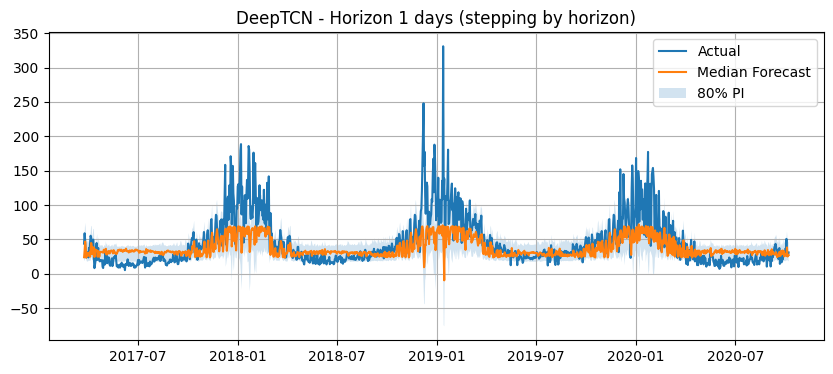

[I 2025-03-25 13:03:41,001] A new study created in memory with name: no-name-01a602c9-a14c-4092-994c-410df1ae87a2
[I 2025-03-25 13:03:42,893] Trial 0 finished with value: 1.145825942357381 and parameters: {'input_size': 66, 'hidden_channels': 64, 'kernel_size': 3, 'num_layers': 4, 'dropout': 0.2847577514796963, 'lr': 0.0076145983290014955}. Best is trial 0 with value: 1.145825942357381.
[I 2025-03-25 13:03:44,146] Trial 1 finished with value: 0.6545918583869934 and parameters: {'input_size': 237, 'hidden_channels': 32, 'kernel_size': 2, 'num_layers': 3, 'dropout': 0.10330983622909284, 'lr': 0.007333109881812659}. Best is trial 1 with value: 0.6545918583869934.
[I 2025-03-25 13:03:44,644] Trial 2 finished with value: 0.9570124348004659 and parameters: {'input_size': 153, 'hidden_channels': 32, 'kernel_size': 2, 'num_layers': 3, 'dropout': 0.14942004308936638, 'lr': 0.00017556799252013092}. Best is trial 1 with value: 0.6545918583869934.
[I 2025-03-25 13:03:45,173] Trial 3 finished with 

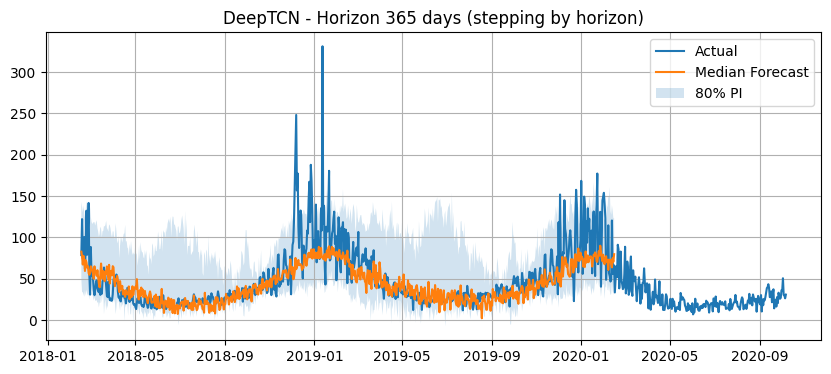

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
from torch.utils.data import DataLoader, TensorDataset, random_split
import optuna
import os

# -----------------------------
# DeepTCN Model
# -----------------------------

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, dilation, kernel_size, dropout):
        super().__init__()
        padding = (kernel_size - 1) * dilation
        self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size, dilation=dilation, padding=padding)
        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels, in_channels, kernel_size, dilation=dilation, padding=padding)
        self.bn2 = nn.BatchNorm1d(in_channels)
        self.relu2 = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        out = self.conv1(x)[..., :x.size(-1)]
        out = self.relu1(self.bn1(out))
        out = self.dropout(out)
        out = self.conv2(out)[..., :x.size(-1)]
        out = self.relu2(self.bn2(out))
        out = self.dropout(out)
        return out + residual



class DeepTCNQuantile(nn.Module):
    def __init__(self, input_size, horizon, num_quantiles=3, num_layers=5, kernel_size=2,
                 hidden_channels=32, dropout=0.2):
        super().__init__()
        self.encoder = nn.Sequential(*[
            ResidualBlock(hidden_channels, 2**i, kernel_size, dropout) if i > 0 else
            nn.Sequential(
                nn.Conv1d(1, hidden_channels, kernel_size, padding=(kernel_size - 1)),
                nn.ReLU()
            ) for i in range(num_layers)
        ])
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        flat_size = self.infer_flat_size(self.encoder, input_size, self.device)
        self.decoder = nn.Sequential(
            nn.Linear(flat_size, 128),
            nn.BatchNorm1d(128), nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64), nn.ReLU(),
            nn.Linear(64, horizon * num_quantiles)
        )
        self.horizon = horizon
        self.num_quantiles = num_quantiles

    def forward(self, x):
        x = x.transpose(1, 2)  # [B, 1, T]
        x = self.encoder(x)
        # print("Encoder out:", x.shape)
        x = x[..., -1 * x.size(-1):]
        x = x.flatten(start_dim=1)
        # print("Flattened:", x.shape)
        x = self.decoder(x)
        return x.view(-1, self.horizon, self.num_quantiles)

    def infer_flat_size(self, encoder, input_size, device):
      with torch.no_grad():
          param_device = next(encoder.parameters()).device
          dummy_input = torch.zeros(1, 1, input_size, device=param_device)

          out = encoder(dummy_input)
          out = out[..., -1 * out.size(-1):] # causal trim (optional)
          return out.flatten(start_dim=1).shape[1] # [1, channels * time]

def quantile_loss(y_true, y_pred, quantiles):
    loss = 0
    for i, q in enumerate(quantiles):
        e = y_true - y_pred[:, :, i]
        loss += torch.max(q * e, (q - 1) * e).mean()
    return loss

# -----------------------------
# Forecast Direct Function
# -----------------------------

def forecast_direct(model, series, input_size, horizon, quantiles):
    model.eval()
    preds = []
    i = 0
    while i + input_size + horizon <= len(series):
        window = series[i:i+input_size]
        # x = torch.tensor(window, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
        x = torch.tensor(window, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(next(model.parameters()).device)

        with torch.no_grad():
            out = model(x).squeeze(0).cpu().numpy()  # shape: [horizon, quantiles]
        preds.append(out)
        i += horizon
    return np.concatenate(preds, axis=0)

def forecast_direct_aligned_horizon(model, series, input_size, horizon, quantiles):
    """
    Step forward by `horizon` each time,
    but store each forecast block in the correct positions of a timeline array.
    """
    model.eval()

    # We'll store predictions for indices up to len(series).
    # Because each chunk forecasts horizon steps from i+input_size to i+input_size+horizon-1
    # we'll allocate shape [len(series), num_quantiles].
    preds = np.full((len(series), len(quantiles)), np.nan)

    i = 0
    while i + input_size + horizon <= len(series):
        # Take the input window
        window = series[i : i + input_size]
        x = torch.tensor(window, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
        x = x.to(next(model.parameters()).device)

        # Forward pass: horizon-step forecast
        with torch.no_grad():
            out = model(x).squeeze(0).cpu().numpy()  # shape: [horizon, num_quantiles]

        # Store each horizon-step forecast in the correct timeline index
        # chunk covers times [i+input_size, i+input_size+1, ..., i+input_size+horizon-1]
        for step in range(horizon):
            preds[i + input_size + step] = out[step]

        i += horizon  # move forward by horizon

    return preds  # shape: [len(series), num_quantiles] (NaNs where no forecast is placed)



# -----------------------------
# Dataset Preparation
# -----------------------------

def prepare_dataset(df, input_size, horizon):
    X, y = [], []
    for i in range(len(df) - input_size - horizon):
        X.append(df['y_scaled'].values[i:i+input_size])
        y.append(df['y_scaled'].values[i+input_size:i+input_size+horizon])
    X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
    y = torch.tensor(y, dtype=torch.float32)
    return TensorDataset(X, y)

# -----------------------------
# MAIN
# -----------------------------

if __name__ == "__main__":
    import random
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    NUM_TRIALS = 20


    df = pd.read_csv('/content/drive/MyDrive/airkaz/selected_sensors2_cleaned.csv', index_col=0)
    df = df.rename(columns={'full_date': 'ds', '2': 'y'})
    df['ds'] = pd.to_datetime(df['ds'])
    df['unique_id'] = 'sensor_2'

    scaler = StandardScaler()
    df['y_scaled'] = scaler.fit_transform(df[['y']])
    full_series = df['y_scaled'].values

    results = []
    quantiles = [0.1, 0.5, 0.9]
    test_lengths = list(range(30, 181, 30)) + [240, 300, 360, 480, 600, 720, len(df)]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    for horizon in [1, 365]:
        def objective(trial):
            input_size = trial.suggest_int("input_size", min(30, horizon), min(365, horizon*2))
            hidden_channels = trial.suggest_categorical("hidden_channels", [32, 64, 128])
            kernel_size = trial.suggest_categorical("kernel_size", [2, 3])
            num_layers = trial.suggest_int("num_layers", 3, 6)
            dropout = trial.suggest_float("dropout", 0.1, 0.4)
            lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)

            dataset = prepare_dataset(df, input_size, horizon)
            N = len(dataset)

            train_end = int(N * 0.6)
            val_end = int(N * 0.8)

            train_ds = torch.utils.data.Subset(dataset, range(0, train_end))
            val_ds = torch.utils.data.Subset(dataset, range(train_end, val_end))

            train_loader = DataLoader(train_ds, batch_size=64, shuffle=False)
            val_loader = DataLoader(val_ds, batch_size=64)

            model = DeepTCNQuantile(input_size, horizon, num_quantiles=len(quantiles),
                                    num_layers=num_layers, kernel_size=kernel_size,
                                    hidden_channels=hidden_channels, dropout=dropout)
            model = model.to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            best_loss, patience, counter, best_epoch = float('inf'), 5, 0, 0
            for epoch in range(50):
                model.train()
                for xb, yb in train_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    optimizer.zero_grad()
                    preds = model(xb)
                    loss = quantile_loss(yb, preds, quantiles)
                    loss.backward()
                    optimizer.step()
                model.eval()
                val_loss = np.mean([
                    quantile_loss(yb.to(device), model(xb.to(device)), quantiles).item()
                    for xb, yb in val_loader
                ])
                if val_loss < best_loss:
                    best_loss = val_loss
                    best_epoch = epoch
                    counter = 0
                else:
                    counter += 1
                    if counter >= patience:
                        break
            trial.set_user_attr("best_epoch", best_epoch)
            return best_loss

        study = optuna.create_study(direction="minimize")
        study.optimize(objective, n_trials=NUM_TRIALS)
        best_params = study.best_trial.params

        # Retrain best model
        best_epoch_num = study.best_trial.user_attrs["best_epoch"]
        input_size = best_params['input_size']

        dataset = prepare_dataset(df, input_size, horizon)
        N = len(dataset)

        train_end = int(N * 0.6)
        val_end = int(N * 0.8)

        train_ds = torch.utils.data.Subset(dataset, range(0, train_end))
        val_ds = torch.utils.data.Subset(dataset, range(train_end, val_end))

        train_loader = DataLoader(train_ds, batch_size=64, shuffle=False)
        val_loader = DataLoader(val_ds, batch_size=64)

        model = DeepTCNQuantile(input_size, horizon, num_quantiles=len(quantiles), **{k: best_params[k] for k in best_params if k != 'input_size' and k != 'lr'})
        model = model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])

        for epoch in range(best_epoch_num):
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                preds = model(xb)
                loss = quantile_loss(yb, preds, quantiles)
                loss.backward()
                optimizer.step()

        # pred_scaled = forecast_direct(model, full_series, input_size, horizon, quantiles)
        # pred_median = scaler.inverse_transform(pred_scaled[:, 1].reshape(-1, 1)).flatten()
        # test_actual = df['y'].values[-len(pred_median):]
        # test_df_copy = pd.DataFrame({"ds": df['ds'].values[-len(pred_median):], "y": test_actual, "forecast": pred_median})

        pred_scaled = forecast_direct_aligned_horizon(model, full_series, input_size, horizon, quantiles)
        pred_median = scaler.inverse_transform(pred_scaled[:, [1]]).ravel()
        pred_q10 = scaler.inverse_transform(pred_scaled[:, [0]]).ravel()
        pred_q90 = scaler.inverse_transform(pred_scaled[:, [2]]).ravel()

        # Add columns to your DataFrame
        df['q10'] = pred_q10
        df['median'] = pred_median
        df['q90'] = pred_q90

        # Optionally slice off the warmup portion (0 to input_size-1)
        # if you only care about the portion after the first forecast
        valid_start = input_size
        df_valid = df.iloc[valid_start:].copy()

        plt.figure(figsize=(10, 4))
        plt.plot(df_valid['ds'], df_valid['y'], label='Actual')
        plt.plot(df_valid['ds'], df_valid['median'], label='Median Forecast')
        plt.fill_between(
            df_valid['ds'], df_valid['q10'], df_valid['q90'],
            alpha=0.2, label='80% PI'
        )
        plt.title(f'DeepTCN - Horizon {horizon} days (stepping by horizon)')
        plt.legend()
        plt.grid(True)
        plt.show()

    pd.DataFrame(results).to_csv("deep_tcn_quantile_results.csv", index=False)


## MCN

[Epoch 1] Train Loss: 1.2060 | Val MAPE: 1.022
[Epoch 2] Train Loss: 1.1855 | Val MAPE: 1.086
[Epoch 3] Train Loss: 1.1809 | Val MAPE: 1.121
[Epoch 4] Train Loss: 1.1702 | Val MAPE: 1.183
[Epoch 5] Train Loss: 1.1600 | Val MAPE: 1.132
[Epoch 6] Train Loss: 1.1424 | Val MAPE: 1.305
[Epoch 7] Train Loss: 1.1410 | Val MAPE: 1.120
[Epoch 8] Train Loss: 1.1412 | Val MAPE: 1.314
[Epoch 9] Train Loss: 1.1275 | Val MAPE: 1.192
[Epoch 10] Train Loss: 1.1106 | Val MAPE: 1.323
[Epoch 11] Train Loss: 1.1034 | Val MAPE: 1.231
[Epoch 12] Train Loss: 1.1130 | Val MAPE: 1.168
[Epoch 13] Train Loss: 1.0971 | Val MAPE: 1.185
[Epoch 14] Train Loss: 1.0845 | Val MAPE: 1.292
[Epoch 15] Train Loss: 1.0866 | Val MAPE: 1.133
[Epoch 16] Train Loss: 1.1098 | Val MAPE: 1.420
[Epoch 17] Train Loss: 1.0770 | Val MAPE: 1.371
[Epoch 18] Train Loss: 1.0712 | Val MAPE: 1.171
[Epoch 19] Train Loss: 1.0530 | Val MAPE: 1.208
[Epoch 20] Train Loss: 1.0646 | Val MAPE: 1.381

Final Test MAE: 6.701, MAPE: 0.376
⚠️ ds_range l

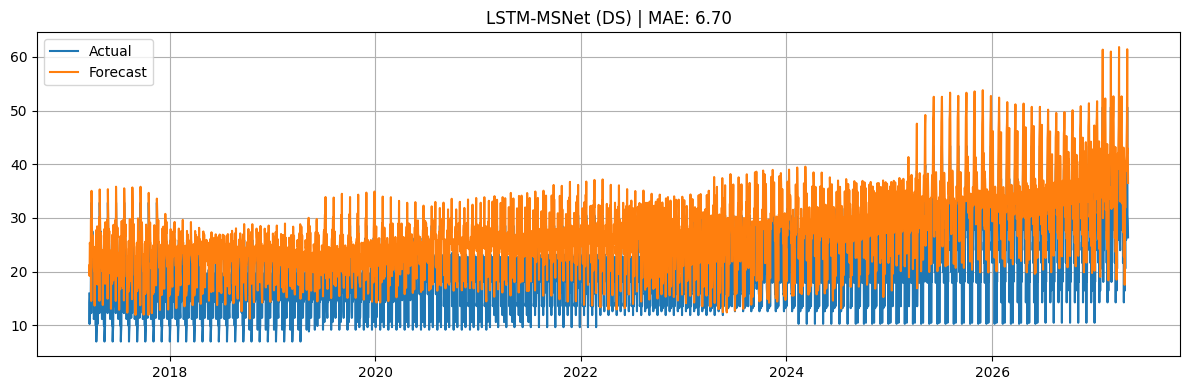

ValueError: too many values to unpack (expected 2)

In [ ]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
from datetime import timedelta
from statsmodels.tsa.seasonal import STL
from prophet import Prophet
import matplotlib.pyplot as plt

# -----------------------------
# 1. Seasonal Decomposition Helpers
# -----------------------------

def apply_stl_decomposition(y, period):
    stl = STL(y, period=period, seasonal=13)
    result = stl.fit()
    return result.trend, result.seasonal, result.resid

def apply_fourier_decomposition(dates, period, k=2):
    t = np.arange(len(dates))
    components = []
    for i in range(1, k + 1):
        components.append(np.sin(2 * np.pi * i * t / period))
        components.append(np.cos(2 * np.pi * i * t / period))
    return np.stack(components, axis=1)  # shape: [time, 2k]

def apply_prophet_seasonality(df, seasonalities=[("yearly", 365), ("weekly", 7)]):
    df_prophet = df[['ds', 'y']].copy()
    m = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
    for name, period in seasonalities:
        m.add_seasonality(name=name, period=period, fourier_order=3)
    m.fit(df_prophet)
    future = m.make_future_dataframe(periods=0)
    forecast = m.predict(future)
    seasonal_components = forecast[[f'{name}_seasonality' for name, _ in seasonalities]].values
    return seasonal_components  # shape: [T, num_components]

# -----------------------------
# 2. Dataset Windowing Function (for DS or SE)
# -----------------------------

class WindowedForecastDataset(Dataset):
    def __init__(self, y, input_size, horizon, seasonal_components=None, mode='DS'):
        self.y = y
        self.mode = mode
        self.X = []  # main series windows
        self.Y = []  # target windows (in scaled space)
        # For DS mode we also store seasonal for target window
        self.seasonal = seasonal_components if seasonal_components is not None else None

        for i in range(len(y) - input_size - horizon):
            x = y[i:i+input_size]
            y_out = y[i+input_size:i+input_size+horizon]
            if mode == 'DS':
                self.X.append(x)
                self.Y.append(y_out)
            elif mode == 'SE':
                # For exogenous seasonality, also return seasonal components for the window and target
                x_season = seasonal_components[i:i+input_size]
                y_season = seasonal_components[i+input_size:i+input_size+horizon]
                self.X.append((x, x_season, y_season))
                self.Y.append(y_out)

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        if self.mode == 'DS':
            # Return main series and also the seasonal for the forecast window
            x = torch.tensor(self.X[idx], dtype=torch.float32).unsqueeze(-1)  # shape: [input_size, 1]
            horizon = len(self.Y[idx])
            if self.seasonal is not None:
                # seasonal for forecast window (in original scale)
                y_season = self.seasonal[idx + x.shape[0] : idx + x.shape[0] + horizon]
                y_season = torch.tensor(y_season, dtype=torch.float32).unsqueeze(-1)
            else:
                y_season = None
            return (x, y_season), torch.tensor(self.Y[idx], dtype=torch.float32)
        elif self.mode == 'SE':
            x_main, x_season, y_season = self.X[idx]
            x_main = torch.tensor(x_main, dtype=torch.float32).unsqueeze(-1)
            x_season = torch.tensor(x_season, dtype=torch.float32)
            y_season = torch.tensor(y_season, dtype=torch.float32)
            return (x_main, x_season, y_season), torch.tensor(self.Y[idx], dtype=torch.float32)

# -----------------------------
# 3. LSTM-MSNet (Shared Core)
# -----------------------------

class LSTM_MSNet(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1, season_exog_size=0):
        super().__init__()
        self.use_exog = season_exog_size > 0
        # Here, input_size refers to the feature dimension (always 1 for main series)
        rnn_input_size = 1 + season_exog_size if self.use_exog else 1
        self.rnn = nn.LSTM(rnn_input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x_main, x_season=None):
        if self.use_exog:
            # Concatenate along feature dimension
            x = torch.cat([x_main, x_season], dim=-1)  # shape: [B, T, 1 + season_exog_size]
        else:
            x = x_main
        out, _ = self.rnn(x)
        out = self.linear(out[:, -1])  # use last hidden state; shape: [B, output_size]
        return out

# -----------------------------
# 4. Training Logic
# -----------------------------

def train_msnet(model, dataloader, optimizer, loss_fn, device, mode):
    model.train()
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        # For SE mode, batch[0] is a tuple of 3 elements; for DS mode we now return a tuple (x, seasonal) even if unused by the model.
        if isinstance(batch[0], tuple):
            if mode == 'SE':
                (x_main, x_season, _), y = batch
                x_main, x_season, y = x_main.to(device), x_season.to(device), y.to(device)
                out = model(x_main, x_season)
            else:  # DS mode: tuple of (x, y_season); model uses only x
                (x, _), y = batch
                x, y = x.to(device), y.to(device)
                out = model(x)
        else:
            (x, _), y = batch
            x, y = x.to(device), y.to(device)
            out = model(x)
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# -----------------------------
# 5. Evaluation & Visualization
# -----------------------------

def evaluate_and_plot(y_true, y_pred, ds_range, title='Forecast'):
    from sklearn.metrics import mean_absolute_error
    # Ensure ds_range is aligned
    if len(ds_range) != len(y_pred):
        print("⚠️ ds_range length mismatch, auto-adjusting...")
        ds_range = pd.date_range(start=ds_range[0], periods=len(y_pred), freq='D')
    mae = mean_absolute_error(y_true, y_pred)
    plt.figure(figsize=(12, 4))
    plt.plot(ds_range, y_true, label="Actual")
    plt.plot(ds_range, y_pred, label="Forecast")
    plt.title(f"{title} | MAE: {mae:.2f}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return mae

# -----------------------------
# 6. Full Training Pipeline for DS and SE
# -----------------------------
def run_training_pipeline(df, mode='DS', horizon=30, period=365, decomposition='stl', n_epochs=20, device='cpu'):
    df = df.copy()
    df['ds'] = pd.to_datetime(df['ds'])
    df = df.sort_values('ds')
    y_raw = df['y'].values
    dates = df['ds'].values

    # 1. Seasonal decomposition
    if decomposition == 'stl':
        trend, seasonal, resid = apply_stl_decomposition(y_raw, period=period)
        # For DS mode, we remove seasonal component; for SE mode we keep the original series.
        y_deseasonal = (resid + trend) if mode == 'DS' else y_raw
        seasonal_features = seasonal.reshape(-1, 1)
    elif decomposition == 'fourier':
        seasonal_features = apply_fourier_decomposition(dates, period=period, k=3)
        y_deseasonal = y_raw if mode == 'SE' else y_raw - seasonal_features.sum(axis=1, keepdims=True).flatten()
    elif decomposition == 'prophet':
        df_prophet = df[['ds', 'y']].copy()
        seasonal_features = apply_prophet_seasonality(df_prophet)
        y_deseasonal = y_raw if mode == 'SE' else y_raw - seasonal_features.sum(axis=1, keepdims=True).flatten()
    else:
        raise ValueError("Invalid decomposition")

    # 2. Normalize
    scaler = StandardScaler()
    y_scaled = scaler.fit_transform(y_deseasonal.reshape(-1, 1)).flatten()
    # In SE mode, we scale seasonal components; in DS mode we keep them in original scale for adding back later.
    if mode == 'SE':
        seasonal_scaled = StandardScaler().fit_transform(seasonal_features)
    else:
        seasonal_scaled = seasonal_features

    # 3. Prepare dataset
    # input_size is the window length (here chosen as a fraction of the horizon)
    input_size = int(horizon * 1.25)
    dataset = WindowedForecastDataset(y_scaled, input_size, horizon, seasonal_components=seasonal_scaled, mode=mode)
    N = len(dataset)
    train_end = int(0.7 * N)
    val_end = int(0.9 * N)
    train_ds = torch.utils.data.Subset(dataset, range(0, train_end))
    val_ds = torch.utils.data.Subset(dataset, range(train_end, val_end))
    test_ds = torch.utils.data.Subset(dataset, range(val_end, N))

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=False)
    val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

    # 4. Model setup
    # For DS mode, season_exog_size = 0; for SE mode, it equals number of seasonal features (here, 1 for stl or prophet, or more for Fourier)
    season_dim = seasonal_scaled.shape[1] if mode == 'SE' else 0
    model = LSTM_MSNet(input_size=1, hidden_size=64, num_layers=2, output_size=horizon, season_exog_size=season_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = torch.nn.MSELoss()

    # 5. Train loop
    for epoch in range(n_epochs):
        train_loss = train_msnet(model, train_loader, optimizer, loss_fn, device, mode)
        model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
            for batch in val_loader:
                if mode == 'SE':
                    (x_main, x_season, _), y = batch
                    x_main, x_season = x_main.to(device), x_season.to(device)
                    pred = model(x_main, x_season).cpu().numpy()
                else:
                    # DS mode: get seasonal info along with main series
                    (x, _), y = batch
                    x = x.to(device)
                    pred = model(x).cpu().numpy()
                val_preds.append(pred)
                val_targets.append(y.numpy())
        val_preds = np.concatenate(val_preds)
        val_targets = np.concatenate(val_targets)
        val_mape = mean_absolute_percentage_error(val_targets, val_preds)
        print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f} | Val MAPE: {val_mape:.3f}")

    # 6. Final evaluation on test set
    test_preds, test_targets = [], []
    with torch.no_grad():
        for batch in test_loader:
            if mode == 'SE':
                (x_main, x_season, _), y = batch
                x_main, x_season = x_main.to(device), x_season.to(device)
                pred_scaled = model(x_main, x_season).cpu().numpy()
                # In SE mode the target series is not deseasonalized, so we simply inverse-transform.
                pred_final = scaler.inverse_transform(pred_scaled)
            else:  # DS mode
                # Here the batch returns (x, y_season) as additional seasonal info.
                (x, y_season), y = batch
                x = x.to(device)
                pred_scaled = model(x).cpu().numpy()  # prediction in scaled deseasonalized space
                # Invert scaling to recover deseasonalized forecast in original scale
                # pred_deseasonal = scaler.inverse_transform(pred_scaled)
                pred_deseasonal = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()

                # y_season is in original (non-scaled) seasonal space; add it back
                pred_final = pred_deseasonal + y_season.squeeze().numpy()
            test_preds.append(pred_final)
            # For targets, do the analogous conversion
            if mode == 'DS':
                # y is scaled deseasonalized target; invert and add seasonal component.
                # target_deseasonal = scaler.inverse_transform(y.numpy())
                target_deseasonal = scaler.inverse_transform(y.numpy().reshape(-1, 1)).flatten()

                target_final = target_deseasonal + y_season.squeeze().numpy()
            else:
                target_final = scaler.inverse_transform(y.numpy())
            test_targets.append(target_final)

    test_preds = np.concatenate(test_preds)
    test_targets = np.concatenate(test_targets)
    # Align date range: note that the dataset starts after the initial window.
    ds_range = df['ds'].values[-len(test_preds):]
    from sklearn.metrics import mean_absolute_error
    mae = mean_absolute_error(test_targets, test_preds)
    mape_ = mean_absolute_percentage_error(test_targets, test_preds)
    print(f"\nFinal Test MAE: {mae:.3f}, MAPE: {mape_:.3f}")
    evaluate_and_plot(test_targets.flatten(), test_preds.flatten(), ds_range, title=f"LSTM-MSNet ({mode})")

if __name__ == "__main__":
    # Example usage:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    df = pd.read_csv('/content/drive/MyDrive/airkaz/selected_sensors2_cleaned.csv', index_col=0)
    df = df.rename(columns={'full_date': 'ds', '2': 'y'})
    # Run with DS mode (deseasonalized forecast with seasonal add-back)
    run_training_pipeline(df, mode='DS', horizon=30, period=365, decomposition='stl', n_epochs=20, device=device)
    # To try SE mode, simply call:
    run_training_pipeline(df, mode='SE', horizon=30, period=365, decomposition='stl', n_epochs=20, device=device)


[Epoch 1] Train Loss: 1.2074 | Val MAPE: 1.021
[Epoch 2] Train Loss: 1.1843 | Val MAPE: 1.094
[Epoch 3] Train Loss: 1.1804 | Val MAPE: 1.116
[Epoch 4] Train Loss: 1.1685 | Val MAPE: 1.177
[Epoch 5] Train Loss: 1.1595 | Val MAPE: 1.129
[Epoch 6] Train Loss: 1.1409 | Val MAPE: 1.306
[Epoch 7] Train Loss: 1.1415 | Val MAPE: 1.106
[Epoch 8] Train Loss: 1.1430 | Val MAPE: 1.354
[Epoch 9] Train Loss: 1.1311 | Val MAPE: 1.197
[Epoch 10] Train Loss: 1.1180 | Val MAPE: 1.340
[Epoch 11] Train Loss: 1.1082 | Val MAPE: 1.254
[Epoch 12] Train Loss: 1.1123 | Val MAPE: 1.251
[Epoch 13] Train Loss: 1.0973 | Val MAPE: 1.182
[Epoch 14] Train Loss: 1.0972 | Val MAPE: 1.352
[Epoch 15] Train Loss: 1.0896 | Val MAPE: 1.131
[Epoch 16] Train Loss: 1.0804 | Val MAPE: 1.456
[Epoch 17] Train Loss: 1.0952 | Val MAPE: 1.138
[Epoch 18] Train Loss: 1.0956 | Val MAPE: 1.309
[Epoch 19] Train Loss: 1.0658 | Val MAPE: 1.153
[Epoch 20] Train Loss: 1.0532 | Val MAPE: 1.374

Final Test MAE: 6.518, 0.16152392327785492
⚠️ ds

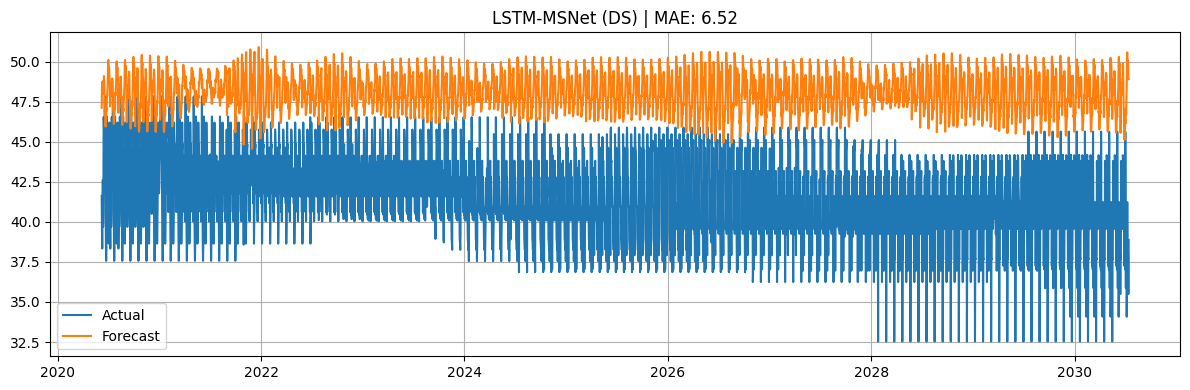

In [ ]:
run_training_pipeline(df[['ds', 'y', 'unique_id']])

## adRNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split
import optuna
import os

class AttentiveDilatedRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, dilation=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dilation = dilation

        self.rnn_cell = nn.GRUCell(input_size, hidden_size)
        self.attn = nn.Linear(hidden_size + input_size, 1)

    def forward(self, x_t, hidden_state):
        if hidden_state is None:
            hidden_state = torch.zeros(x_t.size(0), self.hidden_size, device=x_t.device)
        h_t = self.rnn_cell(x_t, hidden_state)
        attn_input = torch.cat([x_t, h_t], dim=-1)
        alpha = torch.sigmoid(self.attn(attn_input))
        h_t_attn = alpha * h_t + (1 - alpha) * hidden_state
        return h_t_attn

class StackedADRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dilations):
        super().__init__()
        self.cells = nn.ModuleList([
            AttentiveDilatedRNNCell(input_size if i == 0 else hidden_size, hidden_size, d)
            for i, d in enumerate(dilations)
        ])
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        h = None
        for cell in self.cells:
            outputs = []
            h = None
            for t in range(seq_len):
                h = cell(x[:, t, :], h)
                outputs.append(h.unsqueeze(1))
            x = torch.cat(outputs, dim=1)
        out = self.fc(x[:, -1, :])
        return out

def prepare_dataset(df, input_size, horizon):
    X, y = [], []
    for i in range(len(df) - input_size - horizon):
        X.append(df['y_scaled'].values[i:i+input_size])
        y.append(df['y_scaled'].values[i+input_size:i+input_size+horizon])
    X = torch.tensor(np.array(X), dtype=torch.float32).unsqueeze(-1)
    y = torch.tensor(np.array(y), dtype=torch.float32)
    return TensorDataset(X, y)

def forecast_direct(model, series, input_size, horizon):
    model.eval()
    preds = []
    i = 0
    while i + input_size + horizon <= len(series):
        window = series[i:i+input_size]
        window_tensor = torch.tensor(np.array(window), dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
        with torch.no_grad():
            forecast = model(window_tensor).squeeze().cpu().numpy()
        preds.extend(forecast)
        i += horizon
    return np.array(preds)

if __name__ == "__main__":
    df = pd.read_csv('/content/drive/MyDrive/airkaz/selected_sensors2_cleaned.csv', index_col=0)
    df = df.rename(columns={'full_date': 'ds', '2': 'y'})
    df['ds'] = pd.to_datetime(df['ds'])
    df['unique_id'] = 'sensor_2'
    NUM_TRIALS = 10
    TRAIN_TEST_SPLIT = 0.6

    scaler = StandardScaler()
    df['y_scaled'] = scaler.fit_transform(df[['y']])
    horizons = [7, 14, 30, 60, 90, 180, 365]
    total_trials = len(horizons) * NUM_TRIALS  # 10 trials per horizon
    print(f"Total combinations to explore: {total_trials}\n")

    results_summary = {}

    for horizon in horizons:
        print(f"=== Horizon: {horizon} ===")

        def objective(trial):
            input_size = trial.suggest_int("input_size", min(30, horizon), min(365, horizon * 2))
            hidden_size = trial.suggest_categorical("hidden_size", [32, 64, 128, 256])
            learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
            dilations = trial.suggest_categorical("dilations", [(1, 2, 4), (2, 4, 7), (4, 8, 16)])

            dataset = prepare_dataset(df, input_size, horizon)
            train_size = int(TRAIN_TEST_SPLIT * len(dataset))
            val_size = len(dataset) - train_size
            train_ds, val_ds = random_split(dataset, [train_size, val_size])
            train_loader = DataLoader(train_ds, batch_size=64, shuffle=False)
            val_loader = DataLoader(val_ds, batch_size=64)

            model = StackedADRNN(input_size=1, hidden_size=hidden_size, output_size=horizon, dilations=dilations)
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            criterion = nn.SmoothL1Loss()

            best_val_loss = float('inf')
            patience = 8
            trigger_times = 0

            for epoch in range(75):
                model.train()
                for xb, yb in train_loader:
                    optimizer.zero_grad()
                    preds = model(xb)
                    loss = criterion(preds, yb)
                    loss.backward()
                    optimizer.step()

                model.eval()
                val_losses = []
                with torch.no_grad():
                    for xb, yb in val_loader:
                        preds = model(xb)
                        loss = criterion(preds, yb)
                        val_losses.append(loss.item())
                avg_val_loss = np.mean(val_losses)

                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    trigger_times = 0
                else:
                    trigger_times += 1
                    if trigger_times >= patience:
                        break

            return best_val_loss

        study = optuna.create_study(direction="minimize")
        study.optimize(objective, n_trials=NUM_TRIALS)

        best_params = study.best_trial.params
        results_summary[horizon] = {
            "loss": study.best_value,
            "params": best_params
        }
        print(f"Best Loss for Horizon {horizon}: {study.best_value:.4f}")
        print(f"Best Params: {best_params}\n")

    print("=== Summary of Best Results per Horizon ===")
    all_results = []
    for h, res in results_summary.items():
        print(f"Horizon {h} → Loss: {res['loss']:.4f}, Params: {res['params']}")

        # Forecast with best model
        best_params = res['params']
        input_size = best_params['input_size']
        hidden_size = best_params['hidden_size']
        dilations = best_params['dilations']
        lr = best_params['lr']

        model = StackedADRNN(input_size=1, hidden_size=hidden_size, output_size=h, dilations=dilations)
        dataset = prepare_dataset(df, input_size, h)
        train_size = int(0.8 * len(dataset))
        test_ds = list(dataset)[train_size:]
        train_loader = DataLoader(dataset[:train_size], batch_size=64, shuffle=True)

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.SmoothL1Loss()

        for epoch in range(30):
            model.train()
            for xb, yb in train_loader:
                optimizer.zero_grad()
                loss = criterion(model(xb), yb)
                loss.backward()
                optimizer.step()

        # Rolling forecast on test data
        full_series = df['y_scaled'].values
        test_series = full_series[-(input_size + h + 720):]  # make sure we have enough for evaluation
        preds_scaled = forecast_direct(model, test_series, input_size, h)
        preds = scaler.inverse_transform(preds_scaled.reshape(-1, 1)).squeeze()
        actual = df['y'].iloc[-len(preds):].values

        # Evaluate for different test lengths
        max_test_length = len(preds)
        test_lengths = list(range(30, 181, 30)) + [240, 300, 360, 480, 600, 720, max_test_length]
        test_lengths = [t for t in test_lengths if t <= max_test_length]

        error_dict = {}
        for l in test_lengths:
            error_dict[f"MAPE_{l}d"] = mean_absolute_percentage_error(actual[:l], preds[:l])

        all_results.append({
            "Horizon": h,
            "input_size": input_size,
            "hidden_size": hidden_size,
            "lr": lr,
            "dilations": str(dilations),
            **error_dict
        })

    # Save to CSV
    results_df = pd.DataFrame(all_results)
    results_df.to_csv("forecast_eval_by_test_length.csv", index=False)
    print("\nEvaluation results saved to forecast_eval_by_test_length.csv")



[I 2025-03-25 08:39:55,740] A new study created in memory with name: no-name-0af81df2-4505-481d-89df-117cbdacad25


Total combinations to explore: 70

=== Horizon: 7 ===


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2, 4) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 4, 7) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (4, 8, 16) which is of type tuple.
  warnings.warn(message)
[I 2025-03-25 08:40:20,085] Trial 0 finished with value: 0.13477065414190292 and parameters: {'input_size': 14, 'hidden_size': 64, 'lr': 0.0019160187045090251, 'dilations': (1, 2, 4)}. Best is tr

KeyboardInterrupt: 